In [30]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.io
import cmocean 
import sys
sys.path.insert(1, '/Users/emmagurcan/Documents/France/ENS/M1/stageM1/analysis')
from functions_MSM74 import *
import matplotlib.ticker as ticker
import netCDF4 as nc
import cartopy.crs as ccrs
import gsw
from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import griddata
from matplotlib.colors import Normalize

In [57]:
woa_path_long = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/woa23_decav_s08_01.nc"
woa_salinity_path_long = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/woa23_decav91C0_t08_01.nc"
woa_salinity_path = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/2015-2022_mean/woa23_B5C2_t08_01.nc"
woa_path = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/2015-2022_mean/woa23_decav_s08_01.nc"
woa_path14 = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/woa23_B5C2_t08_01_14.nc"
raw_ctd = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/raw_ctd.nc"
clean = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_ctd.nc"
clean_lonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_lonlatev.nc"
nclonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_lonlat.nc"
readcp = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74-VMADCP_allfiles/msm_074_1_vmadcp_75khz_01.nc"
rep = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_CTD.tab"
lon_lat_event = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/lon_lat_event.nc"


In [58]:
dss = nc.Dataset(woa_path)
ds = nc.Dataset(woa_salinity_path)
# ds14 = nc.Dataset(woa_path14)
ds_adcp = nc.Dataset(readcp)
ds_ctd = nc.Dataset(clean)
lonlatev = nc.Dataset(clean_lonlat)

In [59]:
lats = ds['lat']
lons = ds['lon']

In [ ]:
section_num = 4
times, press, depth, T, S, lon, lat, inv_x, lat_adcp_section, lon_adcp_section, depth_adcp, u_adcp, v_adcp = load_data(section_num, lonlatev, ds_ctd, ds_adcp)
cruise = "MSM74"
set_maxdepth(cruise)

In [117]:
distance = determine_distance(lon, lat, inv_x, section_num)
distance_adcp = determine_distance(lon_adcp_section, lat_adcp_section, inv_x, section_num)
v_ortho = calc_ortho_vel(section_num, cruise, lon_adcp_section, lat_adcp_section, u_adcp, v_adcp)
mdepth = get_maxdepth()
distance, depth, v_ortho, lon_adcp_section, lat_adcp_section, distance_adcp, times, press, depth, T, S, lon, lat = snip_data(distance, depth, section_num, v_ortho, lon_adcp_section, lat_adcp_section, distance_adcp, times, press, depth, T, S, lon, lat)

if section_num == 1:
    distance_adcp = np.linspace(np.min(distance), np.max(distance), len(distance_adcp))

sigma0 = determine_sigma(S, T, press, lon, lat)

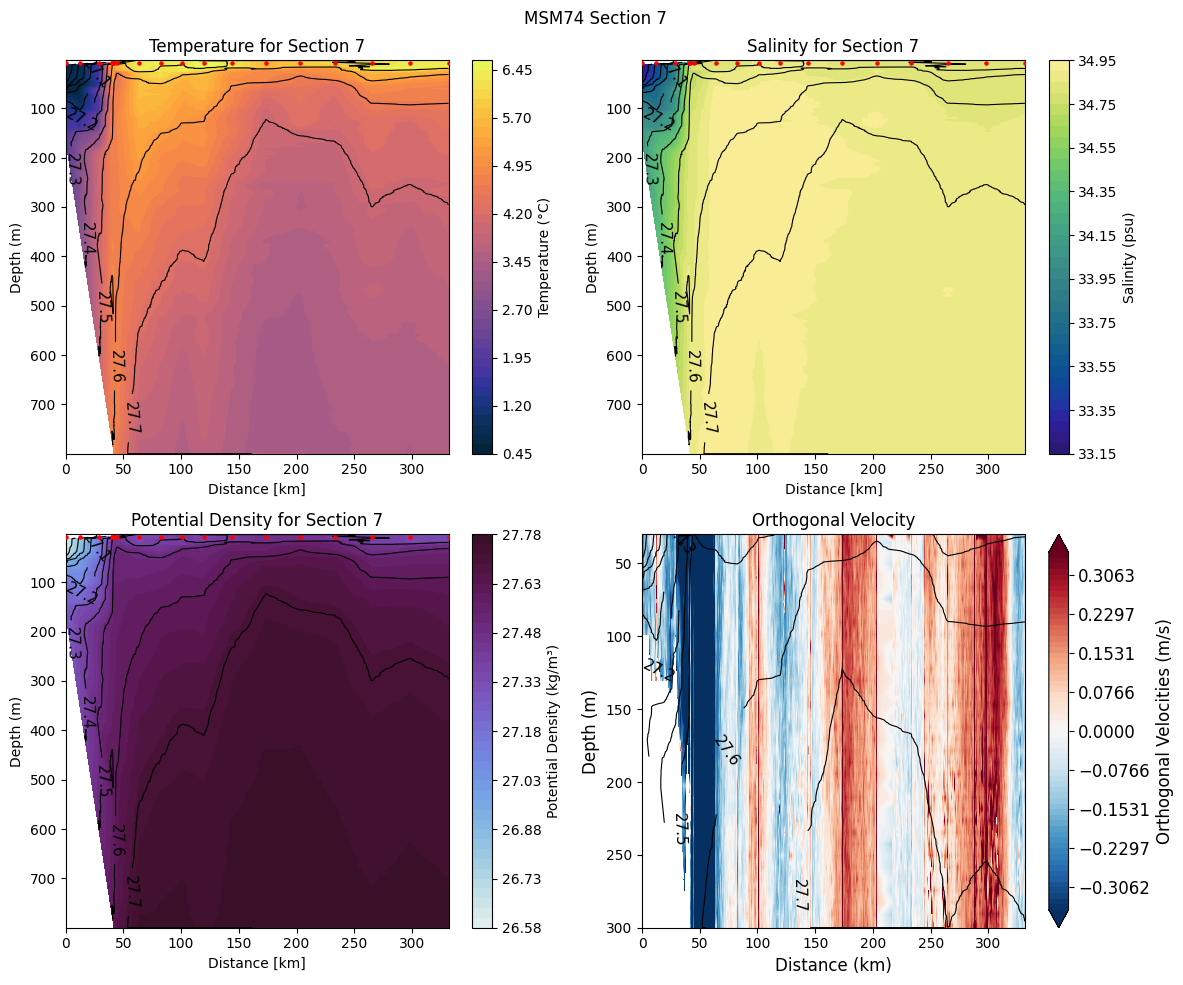

In [118]:
plot_section_data(distance, depth, distance_adcp, depth_adcp, T, S, sigma0, v_ortho, section_num, inv_x=inv_x, depth_max_adcp=300)

In [119]:
t_grid = make_3D(distance, depth, T, section_num)
s_grid = make_3D(distance, depth, S, section_num)
sigma_grid = make_3D(distance, depth, sigma0, section_num)
des = np.linspace(0, mdepth, mdepth)
print(sigma0.shape)
# plt.contourf(np.unique(distance), des, t_grid, cmap=cmocean.cm.thermal, levels=40)
# plt.gca().invert_yaxis()

(11400,)


In [120]:
ds.variables.keys()

dict_keys(['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea'])

In [121]:
# Reference profile
lon_woa = ds['lon']
lat_woa = ds['lat']
t_mn = np.squeeze(ds['t_mn'])
s_mn = np.squeeze(dss['s_mn'])
depth_woa = ds['depth']
print(lon_woa.shape)

(360,)


In [122]:
tref, lon_woa_sel, lat_woa_sel = get_woa_ref(lon, lat, lon_woa, lat_woa, t_mn)
sref, lon_woa_sels, lat_woa_sels = get_woa_ref(lon, lat, lon_woa, lat_woa, s_mn)

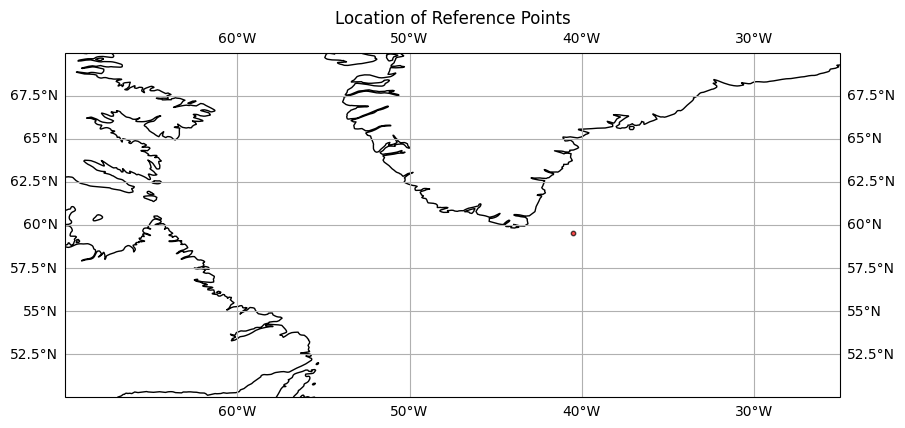

In [123]:
plot_coords(lon_woa_sel, lat_woa_sel, title="Location of Reference Points")


In [124]:
tref.shape

(57,)

In [126]:
anomalyt, ind_X, ind_Z = anom(tref, sref, lon_woa_sel, lat_woa_sel, depth_woa, t_grid, s_grid, sigma_grid, distance, "temperature")
anomalys, ind_X, ind_Z = anom(tref, sref, lon_woa_sel, lat_woa_sel, depth_woa, t_grid, s_grid, sigma_grid, distance, "salinity")
anomalyp, ind_X, ind_Z = anom(tref, sref, lon_woa_sel, lat_woa_sel, depth_woa, t_grid, s_grid, sigma_grid, distance, "density")

Calculating Temperature Anomalies
Calculating Salinity Anomalies
Calculating Density Anomalies
800.0
0.0


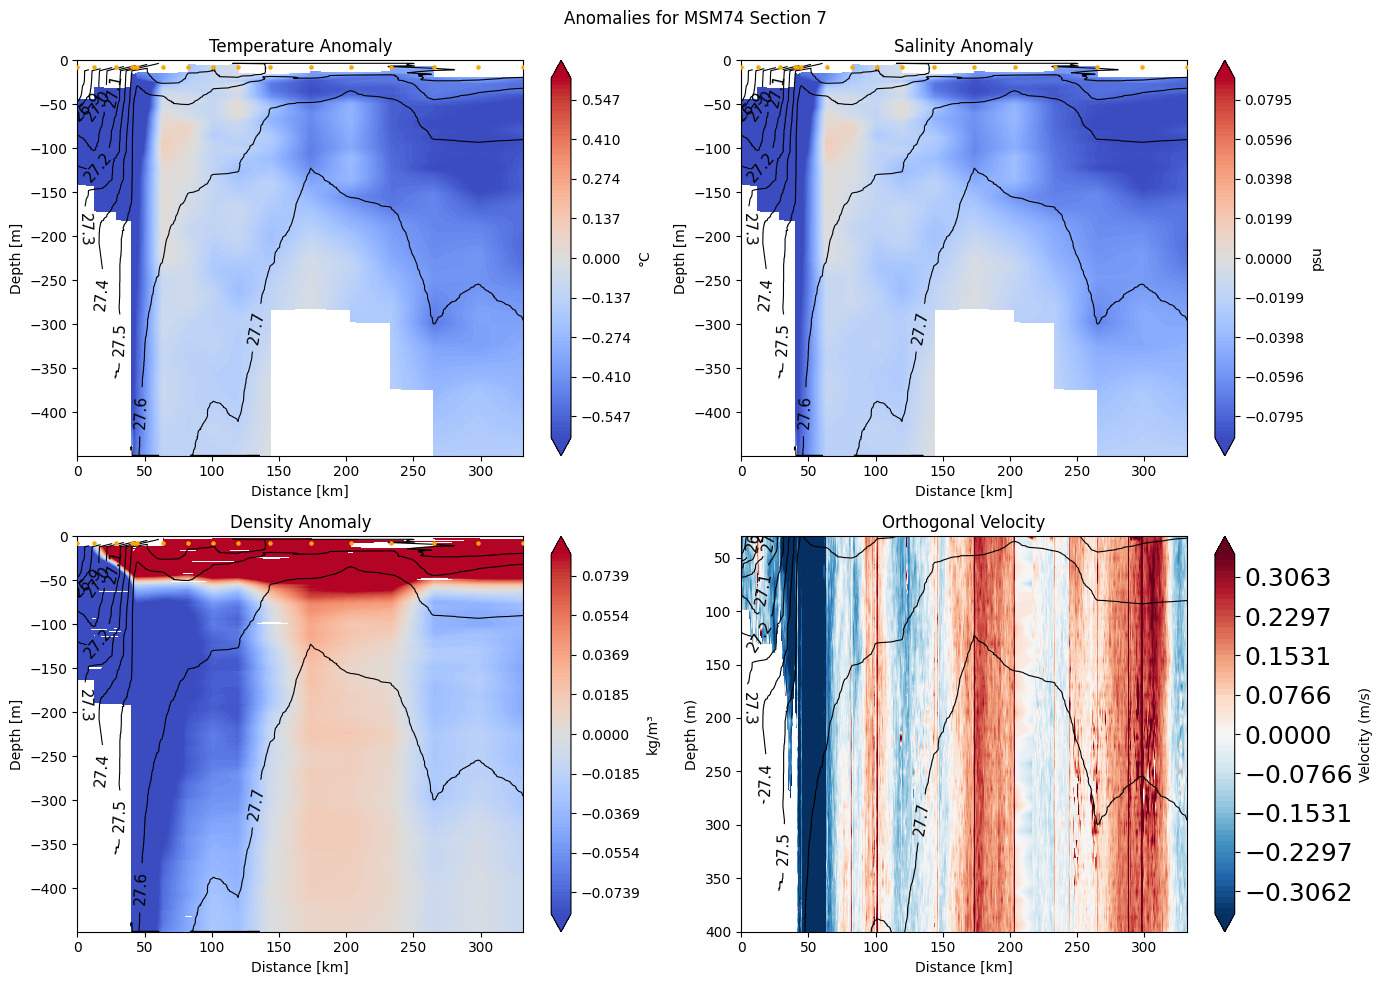

In [136]:
plot_anomalies(distance, ind_Z, anomalyt, anomalys, anomalyp, depth, sigma0, v_ortho, depth_adcp, distance_adcp, section_num, saturation=0.07, saturationd=0.11, inv_x=inv_x, cruise=cruise)